# 인체 직접측정데이터

# 1. Loading Data

In [5]:
import pandas as pd

In [6]:
data3 = pd.read_excel('2015_7차_직접측정 데이터.xlsx')

In [142]:
def name_finder(columns, text):
    for feature in columns:
        if text in feature:
            return feature

def finder(columns, find_list):
    result = []
    for feature in columns:
        for find_num in find_list:
            if find_num in feature:
                result.append(feature)
    if len(result) != len(find_list):
        return 'ERROR!' 
    return result

def make_col_list(columns, num_dict):
    col_dict = {}
    for part in num_dict.items():
        result = finder(columns, part[1])
        if result != 'ERROR!':
            col_dict[part[0]] = result
        else:
            return result
    return col_dict

def to_data_frame(data, col_dict):
    frame_dict = {}
    for col in col_dict.items():
        col[1].insert(0, 'ⓞ_02_성별')
        col[1].insert(1, '①_003_키')
        columns=[]
        for name in col[1]:
            columns.append(name.split('_')[2])
        frame_dict[col[0]] = data[col[1]]
        frame_dict[col[0]].columns = columns
    return frame_dict

def frame_with_gender(frame_dict):
    result_dict = {}
    for frame in frame_dict.items():
        gender_dict = {}
        gender_dict['남'] = frame[1][frame[1]['성별'] == '남']
        gender_dict['여'] = frame[1][frame[1]['성별'] == '여']
        result_dict[frame[0]] = gender_dict
    return result_dict

def dataset_split(frame_dict):
    for items in frame_dict.items():
        for dataset in items[1].items():
            xy_dict = {}
            null_removed = dataset[1].dropna()
            X, y = null_removed[null_removed.columns[2:]], null_removed[null_removed.columns[1]]
            xy_dict['X'], xy_dict['y'] = X, y
            frame_dict[items[0]][dataset[0]] = xy_dict
    return frame_dict

In [116]:
columns = data3.columns
num_dict = {}
num_dict['head'] = ['004', '093', '094', '099', '100', '101', '111', '112', '113', '114', '115', '116', '117']
num_dict['neck'] = ['006', '094', '038', '037']
num_dict['body_top_shoulder'] = ['070', '071', '001', '002', '023', '047', '048', '049', '054', '056', '067']
num_dict['body_top_chest'] = ['018', '019', '024', '025', '041', '039']
num_dict['body_bottom_waist'] = ['020', '021', '026', '027', '043', '042']
num_dict['body_bottom_stomach'] = ['022', '028', '030', '044', '045', '071']
num_dict['leg'] = ['053', '121', '122', '123', '124', '125', '078', '079', '081']
num_dict['foot'] = ['118', '119', '120', '127', '128', '129']
num_dict['arm'] = ['063', '064', '065', '066', '130', '131', '084', '085']
num_dict['hand'] = ['102', '103', '104', '105', '106', '107', '108', '110', '132']

In [117]:
col_dict = make_col_list(columns, num_dict)
frame_dict = to_data_frame(data3, col_dict)
frame_dict = frame_with_gender(frame_dict)
frame_dict['body_top_chest']['남'].drop('젖가슴아래둘레', axis=1, inplace=True)
frame_dict = dataset_split(frame_dict)

### NOTE
* 젖가슴아래둘레는 여자에만 해당하므로 남자에 대한 dataframe에서는 제거해 주었다.
* 전체 데이터에 비해 null값을 가지는 행이 100개 이하였기 때문에 따로 채워넣지 않고 전부 제거해 주었다.

# Linear Regression

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

In [155]:
def linear_regression_result(frame_dict):
    lin_reg = LinearRegression()
    result_list = []
    for (part, gender_dict) in frame_dict.items():
        for (gender, Xy_dict) in gender_dict.items():
            scores = cross_val_score(lin_reg, Xy_dict['X'], Xy_dict['y'], scoring='neg_mean_squared_error', cv=10)
            lin_rmse_scores = np.sqrt(-scores)
            result_list.append([part, gender, lin_rmse_scores.mean()])
    return result_list                

In [157]:
final_result_list = linear_regression_result(frame_dict)

In [180]:
final_result_list

[['head', '남', 11.880583171300556],
 ['head', '여', 9.181195949641543],
 ['neck', '남', 18.288218605326048],
 ['neck', '여', 15.433385591728676],
 ['body_top_shoulder', '남', 45.77760065998323],
 ['body_top_shoulder', '여', 42.10334644289686],
 ['body_top_chest', '남', 56.85636914401857],
 ['body_top_chest', '여', 52.15933846772258],
 ['body_bottom_waist', '남', 54.095350745146995],
 ['body_bottom_waist', '여', 53.50202259687758],
 ['body_bottom_stomach', '남', 47.01293142732554],
 ['body_bottom_stomach', '여', 45.1689572636577],
 ['leg', '남', 28.401324830736257],
 ['leg', '여', 27.098990036947185],
 ['foot', '남', 44.07241779487932],
 ['foot', '여', 43.98427730736562],
 ['arm', '남', 34.73054349834513],
 ['arm', '여', 34.12618814855175],
 ['hand', '남', 45.986212053884465],
 ['hand', '여', 44.406541536658914]]

# Visualizatoin

In [172]:
result_data = pd.DataFrame(final_result_list, columns=['part', 'gender', 'RMSE'])

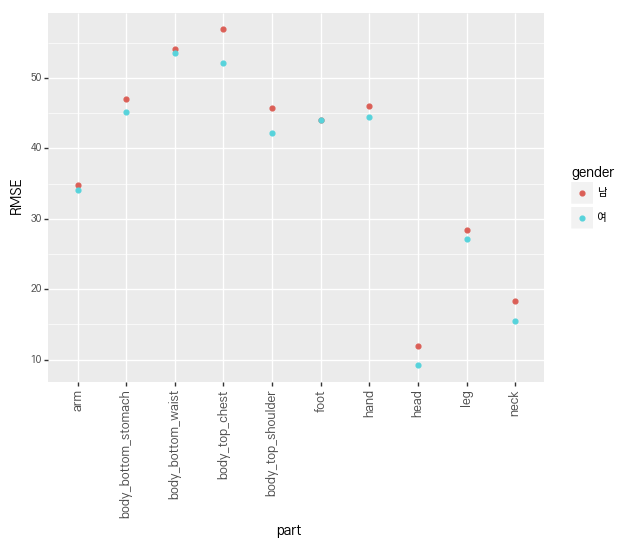

<ggplot: (163414421056)>

In [186]:
from plotnine import *

(ggplot(result_data, aes(x='part', y='RMSE', color='gender'))
 + geom_point()
 + theme(text=element_text(family='LG PC'),
        axis_text_x=element_text(size=10, angle = 90, vjust=1))
)

In [188]:
frame_dict['head']['남']['X'].columns

Index(['눈높이', '머리수직길이', '얼굴수직길이', '눈동자사이너비', '눈구석사이너비', '눈살점', '머리둘레',
       '귀구슬머리위길이', '눈살뒤통수길이', '머리두께', '머리너비', '얼굴너비', '아래턱사이너비'],
      dtype='object')

In [189]:
frame_dict['neck']['남']['X'].columns

Index(['어깨높이', '목둘레', '목밑둘레', '얼굴수직길이'], dtype='object')

# 결과

* 인체 측정 데이터이다 보니 신체사이즈와 신장이 선형적인 관계를 보였고, 그에 따라 Linear Regression이 가장 적합한 모델이었다.

* head의 RMSE가 가장 낮게 평가가 되었는데 이는 head의 columns들 중 '눈높이'와 같이 키와 비슷한 역할을 하는 측정치가 존재하기 때문인것으로 보인다.

* 각 part의 범주적인 특성을 살릴 수 있는 feature들로 구성을 달리하여 학습시켜볼 필요성이 있다.